In [1]:
# Import gradslam related modules
import gradslam as gs
from gradslam import Pointclouds, RGBDImages
from gradslam.datasets import Cofusion, ICL, TUM
from gradslam.slam import PointFusion, ICPSLAM

import matplotlib.pyplot as plt
import numpy as np
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import torch
from torch.utils.data import DataLoader

import time
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
import gc
from GPUtil import showUtilization as gpu_usage
torch.cuda.empty_cache() # clean cuda cache

In [3]:
n_frames = 60#212

data_set = 'ICL'
data_path = '/home/jingkun/Dataset/'
load_masks = False

match data_set:
    case 'CoFusion':
        cofusion_path = data_path + 'CoFusion/'

        sequences = ("room4-full",) # 850 frames

        load_masks = False

        # Load data
        dataset = Cofusion(basedir=cofusion_path, sequences=sequences, seqlen=n_frames, dilation=0, start=300, height=240, width=320, channels_first=False, return_object_mask=load_masks)
    case 'ICL':
        icl_path = data_path + 'ICL/' # associated 880 frames

        # load dataset
        dataset = ICL(icl_path, trajectories=("living_room_traj2_frei_png",) ,seqlen=n_frames, dilation=3, start=0, height=240, width=320, channels_first=False)

    case 'TUM':
        tum_path = data_path + 'TUM/'
        sequences = ("rgbd_dataset_freiburg1_xyz",) # associated 792 frames

        # Load data
        dataset = TUM(basedir= tum_path, sequences=sequences, seqlen=n_frames, dilation=3, height=240, width=320)

loader = DataLoader(dataset=dataset, batch_size=1)
if load_masks:
    colors, depths, intrinsics, poses, *_, names, masks = next(iter(loader))
else:
    colors, depths, intrinsics, poses, *_, names = next(iter(loader))

In [4]:
print(f"colors shape: {colors.shape}")  # torch.Size([2, 8, 240, 320, 3])
print(f"depths shape: {depths.shape}")  # torch.Size([2, 8, 240, 320, 1])
print(f"intrinsics shape: {intrinsics.shape}")  # torch.Size([2, 1, 4, 4])
print(f"poses shape: {poses.shape}")  # torch.Size([2, 8, 4, 4])
print(f"masks shape: {masks.shape}") if load_masks else None# torch.Size([1, 200, 480, 640, 3])
print('---')

colors shape: torch.Size([1, 60, 240, 320, 3])
depths shape: torch.Size([1, 60, 240, 320, 1])
intrinsics shape: torch.Size([1, 1, 4, 4])
poses shape: torch.Size([1, 60, 4, 4])
---


In [5]:
# Create RGB-D image objects 
rgbdimages = RGBDImages(colors.requires_grad_(False),
                        depths.requires_grad_(False), 
                        intrinsics.requires_grad_(False),
                        poses.requires_grad_(False),
                        channels_first=False,
                        )

print(rgbdimages.shape)

rgbdimages.plotly(0).show()

(1, 60, 240, 320)


In [6]:
del loader, colors, depths, poses, intrinsics
gc.collect()
torch.cuda.empty_cache()
gpu_usage()

| ID | GPU | MEM |
------------------
|  0 | 23% | 10% |


## SLAM forward

In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Using device ", device)
slam = PointFusion(odom='dia', numiters=30, dsratio=3, device=device).requires_grad_(False)

print(rgbdimages.channels_first)
pcds, transformation = slam.forward(rgbdimages.to(device))
o3d.visualization.draw_geometries([pcds.open3d(0, max_num_points=n_frames*100000)])

Using device  cuda
False


/home/jingkun/anaconda3/envs/gradslam/lib/python3.10/site-packages/torch/functional.py:504: UserWarning:

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1666642969563/work/aten/src/ATen/native/TensorShape.cpp:3190.)



=========== 3. Pyramid ===========
3. pyramid level
Transformation = 
 tensor([[ 1.0000e+00, -1.3861e-04, -2.7505e-03, -2.6640e-03],
        [ 1.2927e-04,  9.9999e-01, -3.4096e-03,  2.4479e-03],
        [ 2.7509e-03,  3.4093e-03,  9.9999e-01, -3.3753e-04],
        [ 1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00]], device='cuda:0')
=========== 2. Pyramid ===========
2. pyramid level
Transformation = 
 tensor([[ 9.9999e-01,  3.2817e-05, -4.2935e-03, -3.2871e-03],
        [-4.6418e-05,  9.9999e-01, -3.1777e-03,  2.2922e-03],
        [ 4.2934e-03,  3.1778e-03,  9.9999e-01, -1.6941e-04],
        [ 1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00]], device='cuda:0')
=========== 1. Pyramid ===========
1. pyramid level
Transformation = 
 tensor([[ 9.9999e-01,  2.0020e-04, -3.8516e-03, -5.6347e-03],
        [-2.0753e-04,  1.0000e+00, -1.9008e-03, -9.9399e-04],
        [ 3.8513e-03,  1.9016e-03,  9.9999e-01, -4.0515e-06],
        [ 1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00]], device

In [ ]:
poses = transformation.cpu().detach().squeeze().numpy()
print(poses.shape)

## Step-by-step

Using device  cuda
Frame: 0, Time: 0.060
Estimated pose:  [[ 1.0000000e+00  0.0000000e+00  3.9115548e-08  0.0000000e+00]
 [-8.2462814e-11  1.0000000e+00 -6.4364258e-08  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  1.0000000e+00 -1.1920929e-07]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]
=========== 3. Pyramid ===========
3. pyramid level
Transformation = 
 tensor([[ 1.0000e+00, -1.3861e-04, -2.7505e-03, -2.6640e-03],
        [ 1.2927e-04,  9.9999e-01, -3.4096e-03,  2.4479e-03],
        [ 2.7509e-03,  3.4093e-03,  9.9999e-01, -3.3753e-04],
        [ 1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00]], device='cuda:0')
=========== 2. Pyramid ===========
2. pyramid level
Transformation = 
 tensor([[ 9.9999e-01,  3.2817e-05, -4.2935e-03, -3.2871e-03],
        [-4.6418e-05,  9.9999e-01, -3.1777e-03,  2.2922e-03],
        [ 4.2934e-03,  3.1778e-03,  9.9999e-01, -1.6941e-04],
        [ 1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00]], device='cuda:0')
=========== 1. 

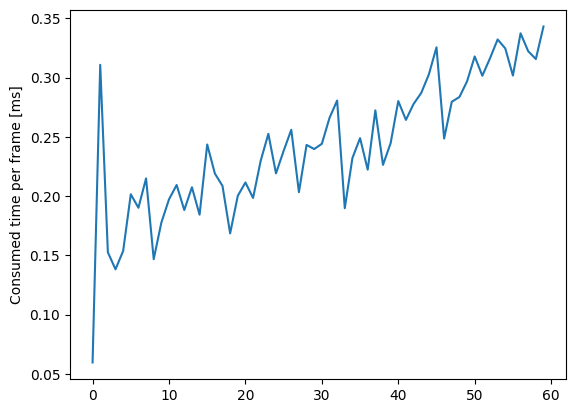

In [9]:
# Fuse point clouds
list_t_frame = []

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Using device ", device)
slam = PointFusion(odom='icp', numiters=10, dsratio=4, device=device).requires_grad_(False)

diaslam = PointFusion(odom='dia', numiters=30, dsratio=3, device=device)

pcds = Pointclouds(device=device)
batch_size, seq_len = rgbdimages.shape[:2]
initial_poses = torch.eye(4, device=device).view(1, 1, 4, 4).expand(batch_size, -1, -1, -1)
prev_frame = None
poses = []

# create visualizer and window.
vis = o3d.visualization.Visualizer()
vis.create_window(height=1000, width=1000)
intermediate_pcd = o3d.geometry.PointCloud()
vis.add_geometry(intermediate_pcd)
R_y_180 = np.eye(4, dtype=float)
R_y_180[0, 0] = R_y_180[2, 2] = -1.0

start_ = time.time()
s = 0
keep_running = True
# for s in range(seq_len):
local_pcds = Pointclouds(device=device)

while keep_running:
    if s < seq_len:
        vis.remove_geometry(intermediate_pcd)
        del intermediate_pcd

        start = time.time()
        live_frame = rgbdimages[:, s].to(device)
        if s == 0 and live_frame.poses is None:
            live_frame.poses = initial_poses

        if s % 1 == 0:
            pcds, live_frame.poses, live_frame.init_T = diaslam.step(pcds, live_frame, prev_frame, inplace=False)
        #     pcds, live_frame.poses, live_frame.init_T = slam.step(pcds, live_frame, prev_frame, inplace=False)
        #     # local_pcds = Pointclouds(device=device)
        # else:
        #     pcds, live_frame.poses, _ = diaslam.step(pcds, live_frame, prev_frame, inplace=False)

        intermediate_pcd = pcds.open3d(0, max_num_points=n_frames*5000)

        intermediate_pcd.transform(R_y_180)

        vis.add_geometry(intermediate_pcd)

        poses.append(live_frame.poses.cpu().detach().squeeze().numpy())
        
        prev_frame = live_frame if diaslam.odom != 'gt' else None

        list_t_frame.append((time.time() - start))
        print("Frame: %d, Time: %.3f" % (s, list_t_frame[-1]))
        print("Estimated pose: ", poses[s])

        del live_frame
        gc.collect()
        torch.cuda.empty_cache()
    s += 1

    keep_running = vis.poll_events()
    vis.update_renderer()

print('Overall time :%.3f' % (time.time() - start_))
# o3d.visualization.draw_geometries([pcds.open3d(0, max_num_points=n_frames*100000)])

vis.destroy_window()

# Plot graph of consumed time per frame
plt.plot(list_t_frame)
plt.ylabel('Consumed time per frame [ms]')
plt.show()

## Read and Visualize Point Clouds

In [ ]:
icl_pcd = o3d.io.read_point_cloud("../results/TUM/dia.pcd")
o3d.visualization.draw_geometries([icl_pcd])

In [ ]:
# static_pcd = o3d.io.read_point_cloud("/home/jingkun/Dataset/CoFusion/room4-noise.klg-export/cloud-0.ply")
# pcd1 = o3d.io.read_point_cloud("/home/jingkun/Dataset/CoFusion/room4-noise.klg-export/cloud-1.ply")
# pcd2 = o3d.io.read_point_cloud("/home/jingkun/Dataset/CoFusion/room4-noise.klg-export/cloud-2.ply")
# pcd3 = o3d.io.read_point_cloud("/home/jingkun/Dataset/CoFusion/room4-noise.klg-export/cloud-3.ply")
# o3d.visualization.draw_geometries([static_pcd, pcd1, pcd2, pcd3])

## Saving Results
### Helper Funciton for converting rotation matrix to quaternion

In [ ]:
def rotation_mat_to_quat(rot_mat: np.ndarray, isprecise: bool = False):
    M = np.array(rot_mat, dtype=np.float64, copy=False)[:4, :4]
    if isprecise:
        q = np.empty((4, ))
        t = np.trace(M)
        if t > M[3, 3]:
            q[0] = t
            q[3] = M[1, 0] - M[0, 1]
            q[2] = M[0, 2] - M[2, 0]
            q[1] = M[2, 1] - M[1, 2]
        else:
            i, j, k = 1, 2, 3
            if M[1, 1] > M[0, 0]:
                i, j, k = 2, 3, 1
            if M[2, 2] > M[i, i]:
                i, j, k = 3, 1, 2
            t = M[i, i] - (M[j, j] + M[k, k]) + M[3, 3]
            q[i] = t
            q[j] = M[i, j] + M[j, i]
            q[k] = M[k, i] + M[i, k]
            q[3] = M[k, j] - M[j, k]
        q *= 0.5 / np.sqrt(t * M[3, 3])
    else:
        m00, m01, m02, m10, m11, m12, m20, m21, m22 = [entry for entry in M[:3, :3].reshape(-1)]
        K = np.array([[m00-m11-m22, 0.0, 0.0, 0.0],
                      [m01+m10, m11-m00-m22, 0.0, 0.0],
                      [m02+m20, m12+m21, m22-m00-m11, 0.0],
                      [m21-m12, m02-m20, m10-m01, m00+m11+m22]])
        K /= 3.0
        # Quaternion is eignevector of K that corresponds to largest eigenvalue
        w, V = np.linalg.eigh(K)
        # q = [x, y, z, w]
        q = V[[0, 1, 2, 3], np.argmax(w)]
    if q[3] < 0.0:
        np.negative(q, q)
    return q


## Save estimates camera poses

In [ ]:
# TODO write a separated function to generate poses txt

In [ ]:
poses_qt = []
# np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.4f}'.format})
for i in range(len(poses)):
    pose = poses[i]
    t = pose[:3, 3].reshape(-1)
    rot_mat = np.identity(4)
    rot_mat[:3, :3] = pose[:3, :3]
    qt = rotation_mat_to_quat(rot_mat).reshape(-1)
    poses_qt.append(np.append(t, qt).astype(np.float16))

# names_list = names[0].strip().split(", ")
names_list = names[0].strip().split()[5::6]

with open("../results/TUM/GradICP.txt", "w") as f:
    for i in range(len(names_list)):
        # outstr = names_list[i][27:]
        outstr = names_list[i]
        # TODO 
        for j in range(len(poses_qt[i])):
            outstr += " "
            outstr += "{:f}".format(poses_qt[i][j])
        # pose_str = ' '.join(map(str, poses_qt[i]))
        # pose_str = np.savetxt(sys.stdout, poses_qt[i], newline=' ', fmt="%.4f")
        f.write(outstr + "\n")

### Save point clouds

In [ ]:
o3d.io.write_point_cloud("../results/TUM/gradicp.pcd", pcds.open3d(0, max_num_points=None), compressed=True)
# del pcds
# gc.collect()
# torch.cuda.empty_cache()

In [ ]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))
torch.cuda.empty_cache() # clean cuda cache

### Step by step map aggregating 
(Visalized via plotly, usable for browser, but really slow for large map)

In [ ]:
import numpy as np 
import plotly.graph_objects as go

def plotly_map_update_visualization(intermediate_pcs, poses, K, max_points_per_pc = 50000, ms_per_frame = 50):
    def plotly_poses(poses, K):
        fx = abs(K[0, 0])
        fy = abs(K[1, 1])
        f = (fx + fy) / 2
        cx = K[0, 2]
        cy = K[1, 2]

        cx = cx / f
        cy = cy / f
        f = 1.

        pos_0 = np.array([0., 0., 0.])
        fustum_0 = np.array(
            [
                [-cx, -cy, f],
                [cx, -cy, f],
                list(pos_0),
                [-cx, -cy, f],
                [-cx, cy, f],
                list(pos_0),
                [cx, cy, f],
                [-cx, cy, f],
                [cx, cy, f],
                [cx, -cy, f]
            ]
        )

        traj = []
        traj_fustums = []
        for pose in poses:
            rot = pose[:3, :3]
            tvec = pose[:3, 3]

            fustum_i = fustum_0 @ rot.T
            fustum_i = fustum_i + tvec
            pos_i = pos_0 + tvec

            pos_i = np.round(pos_i, decimals=2)
            fustum_i = np.round(fustum_i, decimals=2)

            traj.append(pos_i)
            traj_array = np.array(traj)
            traj_fustum = [
                go.Scatter3d(
                    x=fustum_i[:, 0], y=fustum_i[:, 1], z=fustum_i[:, 2],
                    marker=dict(
                        size=0.1
                    ),
                    line=dict(color='purple', width=2)
                ),
                go.Scatter3d(
                    x=pos_i[None, 0], y=pos_i[None, 1], z=pos_i[None, 2],
                    marker=dict(size=0, color='purple')
                ),
                go.Scatter3d(
                    x=traj_array[:, 0], y=traj_array[:, 1], z=traj_array[:, 2],
                    marker=dict(size=0.1),
                    line=dict(color ='purple', width=2)
                )
            ]
            traj_fustums.append(traj_fustum)
        return traj_fustums
        
    def frame_args(duration):
        return {
            "frame": {"duration": duration, "redraw": True},
            "mode": "immediate",
            "fromcurrent": True,
            "transistion": {"duration": duration, "easing": "linear"}
        }

    # visualization
    scatter3d_list = [pc.plotly(0, as_figure=False, max_num_points=max_points_per_pc, point_size=4) for pc in intermediate_pcs]
    traj_frustums = plotly_poses(poses.cpu().numpy(), K.cpu().numpy())
    data = [[*frustum, scatter3d] for frustum, scatter3d in zip(traj_frustums, scatter3d_list)]

    steps = [
        {"args": [[i], frame_args(0)], "label": i, "method": "animate"}
        for i in range(seq_len)
    ]
    sliders = [
        {
            "active": 0,
            "yanchor": "top",
            "xanchor": "left",
            "currentvalue": {"prefix": "Frame: "},
            "pad": {"b": 10, "t": 60},
            "len": 0.9,
            "x": 0.1,
            "y": 0,
            "steps": steps,
        }
    ]
    updatemenus = [
        {
            "buttons": [
                {
                    "args": [None, frame_args(ms_per_frame)],
                    "label": "&#9654;",
                    "method": "animate",
                },
                {
                    "args": [[None], frame_args(0)],
                    "label": "&#9724;",
                    "method": "animate",
                },
            ],
            "direction": "left",
            "pad": {"r": 10, "t": 70},
            "showactive": False,
            "type": "buttons",
            "x": 0.1,
            "xanchor": "right",
            "y": 0,
            "yanchor": "top",
        }
    ]

    fig = go.Figure()
    frames = [{"data": frame, "name": i} for i, frame in enumerate(data)]
    fig.add_traces(frames[0]["data"])
    fig.update(frames=frames)
    fig.update_layout(
        updatemenus=updatemenus,
        sliders=sliders,
        showlegend=False,
        scene=dict(
            xaxis=dict(showticklabels=False, showgrid=False, zeroline=False, visible=False,),
            yaxis=dict(showticklabels=False, showgrid=False, zeroline=False, visible=False,),
            zaxis=dict(showticklabels=False, showgrid=False, zeroline=False, visible=False,),
        ),
        height=1200, width=800
    )
    fig.show()
    return fig

In [ ]:
# dataset = TUM(tum_path, seqlen=20, dilation=19, height=480, width=640)
# loader = DataLoader(dataset=dataset, batch_size=1)
# colors, depths, intrinsics, poses, *_ = next(iter(loader))

# create rgbdimages object
# rgbdimages = RGBDImages(colors, depths, intrinsics, poses)

# step by step SLAM and store intermediate maps
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
slam = PointFusion(odom='dia', device=device)  # use gt poses because large dilation (small fps) makes ICP difficult
pointclouds = Pointclouds(device=device)
batch_size, seq_len = rgbdimages.shape[:2]
initial_poses = torch.eye(4, device=device).view(1, 1, 4, 4).expand(batch_size, -1, -1, -1)
prev_frame = None
intermediate_pcs = []
poses = torch.empty((1,1,4,4), device=device)
for s in range(seq_len):
    live_frame = rgbdimages[:, s].to(device)
    if s == 0 and live_frame.poses is None:
        live_frame.poses = initial_poses
    pointclouds, live_frame.poses = slam.step(pointclouds, live_frame, prev_frame)
    poses = torch.cat((poses, live_frame.poses), dim=1)
    prev_frame = live_frame if slam.odom != 'gt' else None
    intermediate_pcs.append(pointclouds[0])

# visualize
rgbdimages.plotly(0).update_layout(autosize=False, height=600, width=400).show()
fig = plotly_map_update_visualization(intermediate_pcs, poses[0], intrinsics[0, 0], 15000)